# Cross correlation with 2MASS Catalog 

In [1]:
import os,sys
sys.path.append('../')
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
from cmass_modules import *
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
def catalog_masking(cat, nside_out = 128, area=None):
    print 'nside shoud be equal or less than 512'
    print 'input cat ', cat.size
    cat = reddening_mask(cat = cat, nside_out = nside_out)
    print 'reddening ', cat.size
    if area is 'NGC' :
        cat = boss_mask(cat=cat, nside_out = 1024, area=area)
    elif area is 'SGC' :
        cat = boss_mask(cat=cat, nside_out = 1024, area=area)    
    elif area is 'SPT':
        cat = Cuts.keepGoodRegion(cat)
        cat = cat[cat['DEC']<-3.0]
        #cat = y1gold_mask(cat = cat, nside_out = nside_out)
    else : print 'area keyword input : either one of NGC SGC SPT'
        
    print 'output ', cat.size
    return cat

In [3]:
def making_healpix_density_map(cat = None, nside = 128, nest = False, ext_weight = None):
    hpind = np.arange(hp.nside2npix(nside))
    cat_ind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside= nside, nest= nest)
    N_gal, _ = np.histogram(cat_ind, bins = np.append(hpind, hpind.size) )   
    
    seen = (N_gal != 0.0)
    pixarea = hp.nside2pixarea(nside = nside)
    ra,dec = hpHEALPixelToRaDec(hpind, nside = nside)
    Map = np.zeros( (hpind.size, ), dtype = [('RA', 'float'),('DEC', 'float'),('PIXEL', 'float'), ('N_GAL', 'float') \
                                            , ('WEIGHT', 'int'), ('KAPPA', 'float')])
    Ntot = cat.size
    Npix = np.sum(seen)
    Atot = pixarea * Npix
    ntot = Ntot *1./Atot
    ngal = N_gal *1./pixarea
    

    print 'Ntot', Ntot
    #print 'Ngal', N_gal
    print 'mean Ngal', np.mean(N_gal[seen])
    print 'Npix', Npix
    #print 'Map.size', Map.shape
    Map['RA'] = ra
    Map['DEC'] = dec
    Map['PIXEL'] = hpind
    Map['N_GAL'] = N_gal 
    Map['WEIGHT'] = seen #  ( ngal*1./ntot - 1.)*1./Npix
    Map['KAPPA'] =  (N_gal*1./Ntot * Npix -1.)
    #Map['KAPPA'][~seen] = 0.0
    #Map['WEIGHT'][unseen] = 0
    #Map['WEIGHT_RAND'] = unseen
    return Map

In [4]:
def _making_healpix_density_map(cat = None, nside = 128, nest = False):
    hpind = np.arange(hp.nside2npix(nside))
    cat_ind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside= nside, nest= nest)
    N_gal, _ = np.histogram(cat_ind, bins = np.append(hpind, hpind.size) )
    seen = (N_gal != 0.0)
    pixarea = hp.nside2pixarea(nside = nside)
    ra,dec = hpHEALPixelToRaDec(hpind, nside = nside)
    Map = np.zeros( (hpind.size, ), dtype = [('RA', 'float'),('DEC', 'float'),('PIXEL', 'float'), ('N_GAL', 'float') \
                                            , ('WEIGHT', 'int'), ('KAPPA', 'float') , ('WEIGHT_RAND', 'int') ])
    Ntot = cat.size
    Npix = len(set(cat_ind))
    print np.sum(seen), Npix
    Atot = pixarea * Npix
    ntot = Ntot *1./Atot
    ngal = N_gal *1./pixarea
    

    print 'Ngaltot', Ntot
    print 'Ngal mean', np.mean(N_gal)
    #print 'Ngal', N_gal
    print 'Npix', Npix
    print 'Map.size', Map.shape
    Map['RA'] = ra
    Map['DEC'] = dec
    Map['PIXEL'] = hpind
    Map['N_GAL'] = N_gal 
    #Map['WEIGHT'] = (N_gal*1./Ntot * Npix -1.)#  ( ngal*1./ntot - 1.)*1./Npix
    #Map['WEIGHT'][N_gal == 0] = 0
    Map['KAPPA'] =  (N_gal*1./Ntot * Npix -1.)
    #Map['KAPPA'][N_gal==0] = 0.0
    Map['WEIGHT'] = seen
    return Map

In [5]:
def y1gold_mask(cat=None, nside_out = 4096):
    
    path = '/n/des/lee.5922/data/systematic_maps/'
    LSSGoldmask_hpind = fitsio.read(path+'Y1LSSmask_v2_redlimcut_il22_seeil4.0_4096ring.fits')['PIXEL']
    hpind_frac = np.zeros(hp.nside2npix(4096), dtype = 'float')
    hpind_frac[LSSGoldmask_hpind] = 1.0
    if nside_out == 4096 : hpind_frac_ud = hpind_frac
    else : hpind_frac_ud = hp.ud_grade(hpind_frac, pess=True, nside_out = nside_out)
    
    hpind_up = np.arange(hp.nside2npix(nside_out))
    
    cat = cat[cat['DEC']<-3.0]
    cat_hpind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside= nside_out, nest= False) 
    goodind = np.in1d(cat_hpind, hpind_up[[ hpind_frac_ud > 0.8]])
    return cat[goodind]  

In [6]:
def boss_mask(cat=None, area='SGC', nside_out = 1024):
    

    if area is 'SGC' : 
        boss_hpind = esutil.io.read('/n/des/lee.5922/data/cmass_cat/healpix_boss_footprint_SGC_1024.fits')
        
        #boss_hpind = hp.ud_grade(boss_hpind, pess=True, nside_out = nside)

    elif area is 'NGC':
        boss_hpind = esutil.io.read('/n/des/lee.5922/data/cmass_cat/healpix_boss_footprint_NGC_1024.fits')
        #boss_hpind = hp.ud_grade(boss_hpind, pess=True, nside_out = nside)
    else : 
        print 'area keyword input : SGC or NGC'
        return 0
     
    boss_hpfrac = np.zeros(hp.nside2npix(1024), dtype = 'float')
    boss_hpfrac[boss_hpind] = 1.0
    boss_hpind_up = np.arange(hp.nside2npix(nside_out))
    
    if nside_out == 1024 : boss_hpfrac_ud = boss_hpfrac
    else : boss_hpfrac_ud = hp.ud_grade(boss_hpfrac, pess=True, nside_out = nside_out)
    
    #print boss_hpfrac
    
    
    #boss_hpfrac_ud2 = boss_hpfrac_ud.copy()
    #boss_hpfrac_ud2[ boss_hpfrac_ud > 0.8] = 0
    #hp.mollview( boss_hpfrac_ud2, max = 1, nest = False)
    
    #if cat is None : 
    #    boss_hpmask = np.zeros(hp.nside2npix(4096), dtype = 'bool')
    #    boss_hpmask[boss_hpind] = 1
    #    return boss_hpmask
    
    #elif cat is not None : 
        
    hpind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside= nside_out, nest= False) 
    goodind = np.in1d(hpind, boss_hpind_up[[ boss_hpfrac_ud > 0.8]])
    return cat[goodind]

In [7]:
def reddening_mask(cat = None, nside_out = 512):
    
    reddening_nest = esutil.io.read('/n/des/lee.5922/data/2mass_cat/lambda_sfd_ebv.fits', ensure_native=True)
    reddening_ring = hp.reorder(reddening_nest['TEMPERATURE'], inp='NEST', out='RING')
    if nside_out == 512 : reddening_ring_ud = reddening_ring
    else : reddening_ring_ud = hp.ud_grade(reddening_ring, pess=True, nside_out = nside_out)
        
    reddening = rotate_hp_map(reddening_ring_ud, coord = ['C', 'G'])

    reddening_mask = reddening < 0.05 /0.367
    
    hpind_up = np.arange(hp.nside2npix(nside_out))
    
    cathpind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside=  nside_out, nest= False)
    mask = np.in1d(cathpind, hpind_up[reddening_mask])
    

    return cat[mask]

In [8]:
def _making_healpix_density_map(cat = None, nside = 128, nest = False):
    hpind = np.arange(hp.nside2npix(nside))
    cat_ind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside= nside, nest= nest)
    N_gal, _ = np.histogram(cat_ind, bins = np.append(hpind, hpind.size) )
    unseen = (N_gal != 0.0)
    pixarea = hp.nside2pixarea(nside = nside)
    ra,dec = hpHEALPixelToRaDec(hpind, nside = nside)
    Map = np.zeros( (hpind.size, ), dtype = [('RA', 'float'),('DEC', 'float'),('PIXEL', 'float'), ('N_GAL', 'float') \
                                            , ('WEIGHT', 'float') ,  ('WEIGHT_RAND', 'bool') ])
    Map['RA'] = ra
    Map['DEC'] = dec
    Map['PIXEL'] = hpind
    Map['N_GAL'] = N_gal   
    #Map['WEIGHT'] = N_gal*1./pixarea 
    Map['WEIGHT'] = unseen
    return Map

## Masking 2MASS Extended source catalog (XSC) 

In [10]:
reddening_nest = esutil.io.read('/n/des/lee.5922/data/2mass_cat/lambda_sfd_ebv.fits', ensure_native=True)
reddening_ring = hp.reorder(reddening_nest['TEMPERATURE'], inp='NEST', out='RING')
reddening_ring_ud = hp.ud_grade(reddening_ring, nside_out = NSIDE)
reddening = rotate_hp_map(reddening_ring_ud, coord = ['C', 'G'])

#reliable_hp_mask = (reddening < 0.05 / 0.367)

NameError: name 'NSIDE' is not defined

NameError: name 'NSIDE' is not defined

NameError: name 'NSIDE' is not defined

NameError: name 'NSIDE' is not defined

NameError: name 'NSIDE' is not defined

NameError: name 'NSIDE' is not defined

In [ ]:
#from astropy.table import Table
#t = Table.read('/n/des/lee.5922/data/2mass_cat/fp_2mass.fp_xsc9864_k20mag.tbl', format='ipac')
#t.write('/n/des/lee.5922/data/2mass_cat/fp_2mass.fp_xsc9864_k20mag.fits', format='fits', overwrite=True)

In [11]:
def load_2mass_cat():
    import fitsio
    twomass = esutil.io.read('/n/des/lee.5922/data/2mass_cat/fp_2mass.fp_xsc9864_k20mag_ebv.fits', upper=True, ensure_native=True)
    nanmask = ((~np.isnan(twomass['K_M_I20C'])) & (~np.isnan(twomass['J_M_K20FE'])) 
               & (~np.isnan(twomass['K_M_K20FE']))& (~np.isnan(twomass['H_M_K20FE'])))
    twomass = twomass[nanmask]
    twomass_kcorected = twomass['K_M_I20C'] - 0.367 * twomass['EBV'] 
    twomass = rf.append_fields(twomass,'K_M_I20C_correc',twomass_kcorected)
    reliable_mask = ((twomass['EBV'] <0.05/0.367 ))# & (twomass['K_M_I20C_correc'] < 13.85) )
    magcut =  (twomass['K_M_I20C_correc'] < 13.85)
    twomass = twomass[magcut]
    
    #twomass = reddening_mask(cat = twomass, nside_out = 512)
    return twomass

#twomass_galmap = making_healpix_density_map(cat = twomass, nside = NSIDE, nest = False)

In [12]:
def kmag20_mask(twomass):
    mask_k1 = (twomass['K_M_K20FE'] > 12.0) & (twomass['K_M_K20FE'] < 12.5) 
    mask_k2 = (twomass['K_M_K20FE'] > 12.5) & (twomass['K_M_K20FE'] < 13.0) 
    mask_k3 = (twomass['K_M_K20FE'] > 13.0) & (twomass['K_M_K20FE'] < 13.5) 
    mask_k4 = (twomass['K_M_K20FE'] > 13.5) & (twomass['K_M_K20FE'] < 14.0) 
    return mask_k1, mask_k2, mask_k3, mask_k4

In [13]:
def adding_weight_twomass(twomass):
    
    kmask_2 = kmag20_mask(twomass)
    
    print 'mean bias for each luminosity bin'
    b_avg = [1.62, 1.52, 1.54, 1.65]
    print b_avg

    print 'total avg bias '
    b_avg_tot = np.sum([b_avg[i] * np.sum(kmask_2[i]) for i in range(4)])*1./np.sum(kmask_2)
    print b_avg_tot
    
    brel = np.array(b_avg)/b_avg_tot
    
    weight = np.zeros(twomass.size)
    for i in range(4):
        weight[kmask_2[i]] = brel[i]
    
    weight = weight/np.sum(weight)
    twomass = rf.append_fields(twomass,'WEIGHT',weight)
    return twomass

### Cross correlation with CMASS SGC

In [ ]:
from systematics_module.corr import cross_kk_correlation, cross_angular_correlation, _cross_kk_acf

In [9]:
path = '/n/des/lee.5922/data/cmass_cat/'
cmass_sgc = esutil.io.read(path+'galaxy_DR12v5_CMASS_South.fits.gz')
cmass_ngc = esutil.io.read(path+'galaxy_DR12v5_CMASS_North.fits.gz')
cmass_sgc_rand = esutil.io.read(path+'random0_DR12v5_CMASS_South.fits.gz')
cmass_ngc_rand = esutil.io.read(path+'random0_DR12v5_CMASS_North.fits.gz')
random_ind_n = np.random.choice( cmass_ngc_rand.size, size = cmass_ngc_rand.size/10)
random_ind_s = np.random.choice( cmass_sgc_rand.size, size = cmass_sgc_rand.size/10)
cmass_ngc_rand = cmass_ngc_rand[random_ind_n]
cmass_sgc_rand = cmass_sgc_rand[random_ind_s]


dmass_spt = esutil.io.read('../output/n2_2/dmass_spt.fits')
dmass_rand = uniform_random_on_sphere(dmass_spt, size = dmass_spt.size * 10 )
dmass_rand = y1gold_mask(dmass_rand, nside_out = 4096)



#cmass_ngc = cmass_ngc[(cmass_ngc['Z'] < 0.4)] #& (cmass_ngc['Z'] < 0.55)]
#cmass_sgc = cmass_sgc[(cmass_sgc['Z'] < 0.4)] #& (cmass_sgc['Z'] < 0.55)]
#dmass_spt = dmass_spt[(dmass_spt['DESDM_ZP'] > 0.43) & (dmass_spt['DESDM_ZP'] < 0.55)]

#NSIDE = 512
#cmass_ngc_rand = uniform_random_on_sphere(cmass_ngc, size = cmass_ngc.size * 10 )
#cmass_sgc_rand = uniform_random_on_sphere(cmass_sgc, size = cmass_sgc.size * 10 )



"""
NSIDE = 512
cmass_ngc = catalog_masking(cmass_ngc, nside_out = NSIDE, area = 'NGC')
cmass_sgc = catalog_masking(cmass_sgc, nside_out = NSIDE, area = 'SGC')
cmass_ngc_rand = catalog_masking(cmass_ngc_rand, nside_out = NSIDE, area = 'NGC')
cmass_sgc_rand = catalog_masking(cmass_sgc_rand, nside_out = NSIDE, area = 'SGC')
dmass_spt = catalog_masking(dmass_spt, nside_out = NSIDE, area = 'SPT')
dmass_rand = catalog_masking(dmass_rand, nside_out = NSIDE, area = 'SPT')
"""




"\nNSIDE = 512\ncmass_ngc = catalog_masking(cmass_ngc, nside_out = NSIDE, area = 'NGC')\ncmass_sgc = catalog_masking(cmass_sgc, nside_out = NSIDE, area = 'SGC')\ncmass_ngc_rand = catalog_masking(cmass_ngc_rand, nside_out = NSIDE, area = 'NGC')\ncmass_sgc_rand = catalog_masking(cmass_sgc_rand, nside_out = NSIDE, area = 'SGC')\ndmass_spt = catalog_masking(dmass_spt, nside_out = NSIDE, area = 'SPT')\ndmass_rand = catalog_masking(dmass_rand, nside_out = NSIDE, area = 'SPT')\n"

In [ ]:
w_ngc = cmass_ngc['WEIGHT_SYSTOT']*( cmass_ngc['WEIGHT_CP'] + cmass_ngc['WEIGHT_NOZ'] - 1. )
w_rand = np.ones(cmass_ngc_rand.size) #random_sgc['WEIGHT_FKP']

cmass_ngc = appendColumn(cmass_ngc, name = 'WEIGHT', value = w_ngc)
cmass_ngc_rand = appendColumn(cmass_ngc_rand, name = 'WEIGHT_RAND', value = w_rand)

w_sgc = cmass_sgc['WEIGHT_SYSTOT']*( cmass_sgc['WEIGHT_CP'] + cmass_sgc['WEIGHT_NOZ'] - 1. )
w_rand = np.ones(cmass_sgc_rand.size) #random_sgc['WEIGHT_FKP']

cmass_sgc = appendColumn(cmass_sgc, name = 'WEIGHT', value = w_sgc)
cmass_sgc_rand = appendColumn(cmass_sgc_rand, name = 'WEIGHT_RAND', value = w_rand)

In [64]:
twomass = load_2mass_cat()
twomass = adding_weight_twomass(twomass)

twomass_ngc = catalog_masking(twomass, nside_out = 512, area = 'NGC')
twomass_sgc = catalog_masking(twomass, nside_out = 512, area = 'SGC')
twomass_spt = catalog_masking(twomass, nside_out = 512, area = 'SPT')
#twomass_spt = y1gold_mask(twomass, nside_out = 4096)
twomass = None

twomass_ngc_rand = uniform_random_on_sphere(twomass_ngc, size = cmass_ngc.size*10 )
twomass_sgc_rand = uniform_random_on_sphere(twomass_sgc, size = cmass_sgc.size*10 )
twomass_spt_rand = uniform_random_on_sphere(twomass_spt, size = dmass_spt.size*10 )

twomass_ngc_rand = catalog_masking(twomass_ngc_rand, nside_out = 512, area = 'NGC')
twomass_sgc_rand = catalog_masking(twomass_sgc_rand, nside_out = 512, area = 'SGC')
twomass_spt_rand = catalog_masking(twomass_spt_rand, nside_out = 512, area = 'SPT')
#twomass_spt_rand= y1gold_mask(twomass_spt_rand, nside_out = 4096)
print twomass_spt_rand.size


mean bias for each luminosity bin
[1.62, 1.52, 1.54, 1.65]
total avg bias 
1.5927021517080193
nside shoud be equal or less than 512
input cat  938917
reddening  681918
output  179219
nside shoud be equal or less than 512
input cat  938917
reddening  681918
output  66054
nside shoud be equal or less than 512
input cat  938917
reddening  681918
output  32146
nside shoud be equal or less than 512
input cat  6188060
reddening  6045911
output  5101378
nside shoud be equal or less than 512
input cat  2308310
reddening  1632347
output  382119
nside shoud be equal or less than 512
input cat  1123980
reddening  703418
output  234649
234649


# Weighting Twomass galaxies with bias from different luminosity bins

In [ ]:
#nyu_cat = esutil.io.read('/n/des/lee.5922/data/NYU_value_added_cat/object_catalog.fits')
#sdss_spec = esutil.io.read('/n/des/lee.5922/data/NYU_value_added_cat/object_sdss_spectro.fits')
#twomass_spec = esutil.io.read('/n/des/lee.5922/data/NYU_value_added_cat/object_twomass.fits')

In [28]:
from systematics_module.corr import cross_angular_correlation, angular_correlation

In [26]:
"""

dmass_spt = esutil.io.read('../output/n2_2/dmass_spt.fits')
dmass_spt_no_red = y1gold_mask(dmass_spt, nside_out = 4096)
dmass_spt_red = reddening_mask(cat = dmass_spt_no_red, nside_out = 512)
#dmass_spt_red = catalog_masking(dmass_spt, nside_out = 512, area = 'SPT')

dmass_rand = uniform_random_on_sphere(dmass_spt, size = dmass_spt.size * 10 )
dmass_rand_no_red = y1gold_mask(dmass_rand, nside_out = 4096)
dmass_rand_red = reddening_mask(cat = dmass_rand_no_red, nside_out = 512)

twomass = load_2mass_cat()
twomass = adding_weight_twomass(twomass)


twomass_spt = Cuts.keepGoodRegion(twomass)
twomass_spt = twomass_spt[twomass_spt['DEC']<-3.0]
        
twomass_spt_no_red = y1gold_mask(twomass, nside_out = 4096)
twomass_spt_red = reddening_mask(twomass_spt_no_red, nside_out = 512)
twomass = None

twomass_spt_rand = uniform_random_on_sphere(twomass_spt, size = dmass_spt.size*10 )
twomass_spt_rand_no_red= y1gold_mask(twomass_spt_rand, nside_out = 4096)
twomass_spt_rand_red =reddening_mask(cat = twomass_spt_rand_no_red, nside_out = 512)

print dmass_spt.size, dmass_spt_no_red.size, dmass_spt_red.size
print dmass_rand.size, dmass_rand_no_red.size, dmass_rand_red.size

print twomass_spt.size, twomass_spt_no_red.size, twomass_spt_red.size
print twomass_spt_rand.size, twomass_spt_rand_no_red.size, twomass_spt_rand_red.size
"""


mean bias for each luminosity bin
[1.62, 1.52, 1.54, 1.65]
total avg bias 
1.5927021517080193
112398 112398 112368
1123980 510170 510058
32159 32159 32146
1123980 234818 234769


In [ ]:
112398 112368
510209 510103
32159 32146
234379 234346

In [22]:
help(cross_angular_correlation)

Help on function cross_angular_correlation in module systematics_module.corr:

cross_angular_correlation(data=None, data2=None, rand=None, rand2=None, njack=30, nbins=20, min_sep=0.041666666666666664, max_sep=4, weight=None, mpi=True, suffix='', out=None, dir='./')



In [24]:
kmask_d = kmag20_mask(twomass_spt)
cross_angular_correlation(data = dmass_spt, 
                          data2 = twomass_spt[kmask_d[0]|kmask_d[1]|kmask_d[2]|kmask_d[3]], 
                          #data2 = twomass_spt, 
                          rand = dmass_rand, 
                          rand2= dmass_rand, njack = 100, 
                          nbins = 20,
                          weight = [None, None, None, None],
                          min_sep=0.5/60, max_sep=300/60.,
                          dir = '../data_txt/', 
                          suffix = '_2mass_x_dmass_spt_bweight_nbins10_broad_jk100' )

X (1000, 2)  centers (100, 2)  tol=1e-05  maxiter=200
13 iterations  cluster sizes: [ 5 16  9  5 14 20 15  5  8  4 12  6 10  4  2  0 10  9 19 10  3 17 12 14
  6  7  5 16  4 16  3  9 20  5  9  7 15 11  7  7 15  5 15  9 12  8 14  9
 20 12  9  6 15 12 23  8  3 14  6 12 12 14  0 12  8  1  4 16  7  7 13  8
  4 11  4 10 18  6 14 17 17 10  7  3  7  8 13  8  9 18  8 16  5 13 10 22
  6  2 12 17]
X (112398, 2)  centers (100, 2)  tol=1e-05  maxiter=200
123 iterations  cluster sizes: [ 868 1088 1327  932 1314 1522 1154 1094 1042  893 1291  863 1584 1168
 1058 1221  807 1279 1299 1018 1176 1194 1303  993  943 1194 1033 1414
 1063 1151  853 1240 1071  796 1276 1403 1166 1135  972 1116 1164 1003
 1282 1030  951 1200 1370  790  987 1344  680 1155 1270 1006 1331 1186
  810 1101 1256  995 1258 1245 1091 1042 1117  603  974 1284 1469 1773
 1036 1199 1211 1223  964 1119 1186 1287 1464 1004 1213  920  952  471
 1060 1162 1275 1146 1018  970  773 1111  935 1231 1335 1244 1268 1007
 1469 1064]
. . . . . . . 

In [47]:
kmask_d = kmag20_mask(twomass_spt)
angular_correlation(#data = dmass_spt, 
                          data = twomass_spt[kmask_d[0]|kmask_d[1]|kmask_d[2]|kmask_d[3]], 
                          #data2 = twomass_spt, 
                          rand = dmass_rand, 
                          #rand2= dmass_rand, 
                          njack = 100, 
                          nbins = 20,
                          weight = [None, None, None, None],
                          min_sep=0.5/60, max_sep=300/60.,
                          dir = '../data_txt/', 
                          suffix = '_2mass_spt_nbins20_broad_jk100' )

calculate angular correlation function
X (1000, 2)  centers (100, 2)  tol=1e-05  maxiter=200
12 iterations  cluster sizes: [10  8  4 22 19  5 12  7 11 12 18 14  6 13  5  1  3 13 25 12  8  8 12 11
  8  0 10  8 12  4 10 13  7 23  3 12  8 13 12  4  5 13 15  4 10 16 10 12
  8  9 11 10 10 17 11  6 12  6 11 10 11 13  8  6  5  6 14  5  6  8 14  0
 16 21  9 12  7  8  2 11  9  9  9  7 19 11  2 11  9  9  5 11 12 11 10 14
 10  7  5 26]
X (30593, 2)  centers (100, 2)  tol=1e-05  maxiter=200
52 iterations  cluster sizes: [359 237 259 403 342 265 250 261 490 368 523 366 389 364 228 210 218 369
 338 315 330 230 274 330 327 191 277 182 366 242 329 377 321 439 203 231
 293 283 286 358 303 247 403 215 289 351 303 269 197 297 376 243 350 434
 322 228 234 259 284 302 308 451 169 291 207 158 448 182 331 315 271 134
 351 391 254 389 265 202 233 660 376 354 212 258 444 285 242 295 292 286
 240 348 352 368 352 393 299 237 159 462]
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

In [66]:
kmask = kmag20_mask(twomass_ngc)

angular_correlation(data = twomass_ngc[kmask[0]|kmask[1]|kmask[2]|kmask[3]], 
                          rand = cmass_ngc_rand, 
                          #rand2= cmass_ngc_rand, 
                          njack = 20,  
                          nbins = 20,
                          weight = [None, None, None, None], 
                          min_sep=0.5/60, max_sep=300/60.,
                          dir = '../data_txt/', 
                          suffix = '_2mass_ngc_nbins20_broad_jk20' )

 calculate angular correlation function
X (814, 2)  centers (20, 2)  tol=1e-05  maxiter=200
40 iterations  cluster sizes: [33 33 36 34 38 34 43 28 47 37 42 48 37 58 52 42 39 40 38 55]
X (165902, 2)  centers (20, 2)  tol=1e-05  maxiter=200
43 iterations  cluster sizes: [ 8003  7381 10077  8480  6989  7431  7841  7162  9243  9420  7363  8235
  7607  8992 10700  8228  6970  8407  8031  9342]
. . . . . . . . . . . . . . . . . . . . . saving data file to :  ../data_txt//acf_auto_2mass_ngc_nbins20_broad_jk20.txt


In [72]:
kmask = kmag20_mask(twomass_sgc)

cross_angular_correlation(data = twomass_sgc[kmask[0]|kmask[1]|kmask[2]|kmask[3]], 
                          rand = cmass_sgc_rand, 
                          data2 = twomass_sgc[kmask[0]|kmask[1]|kmask[2]|kmask[3]], 
                          rand2= cmass_sgc_rand, 
                          njack = 20,  
                          nbins = 20,
                          weight = [None, None, None, None], 
                          min_sep=0.5/60, max_sep=300/60.,
                          dir = '../data_txt/', 
                          suffix = '_2mass_sgc_nbins20_broad_jk20_auto' )

X (493, 2)  centers (20, 2)  tol=1e-05  maxiter=200
15 iterations  cluster sizes: [10 32 19 23 30 31 27 12 19 23 25 42 34 27 35 11 25 33 15 20]
X (60996, 2)  centers (20, 2)  tol=1e-05  maxiter=200
52 iterations  cluster sizes: [1976 3152 3173 3256 3085 3640 3277 3264 2230 2865 2753 4002 3068 2845
 4232 2635 3165 2750 2621 3007]
 . . . . . . . . . . . . . . . . . . . . . 
saving data file to :  ../data_txt//acf_cross_2mass_sgc_nbins20_broad_jk20_auto.txt


In [26]:
kmask = kmag20_mask(twomass_ngc)

cross_angular_correlation(data = cmass_ngc, 
                          data2 = twomass_ngc[kmask[0]|kmask[1]|kmask[2]|kmask[3]], 
                          rand = cmass_ngc_rand, 
                          rand2= cmass_ngc_rand, 
                          njack = 100,  
                          nbins = 20,
                          weight = [True, True, None, None], 
                          min_sep=0.5/60, max_sep=300/60.,
                          dir = '../data_txt/', 
                          suffix = '_2mass_x_cmass_ngc_sys_cp_noz_weight_nbins10_broad_jk100' )

X (1573, 2)  centers (100, 2)  tol=1e-05  maxiter=200
14 iterations  cluster sizes: [20 16 16  6 19 13 24 17 12 21 12 18 22 21 10 11  9 19  3 15 12 11 32  6
 23 14 12  7 12 22 16 16 25 19 12 22 12 13 15 18 23 16 26 15 15  8 15 12
 16 11 15 19 15 19 17 15 26 20 13 14 16  9 15 16 20 22 15  8 28 15 15  4
 10 11  7 11 18 11 18 26 17 20 13 26 17 14 22 12  5 19 23 17 10 15 10 18
 14 11 17 25]
X (618806, 2)  centers (100, 2)  tol=1e-05  maxiter=200
130 iterations  cluster sizes: [5917 7371 7077 6859 6957 6318 5943 6187 6163 6492 6787 6090 7150 6447
 5777 6853 5313 5466 6239 6820 5565 6594 6728 5979 6610 5931 5837 6981
 5013 5667 7195 5838 6181 5999 5668 7242 6288 5259 6395 6125 7164 6498
 6205 5612 6674 5788 6673 5844 5012 5624 6553 6782 6071 5922 6137 4808
 6330 6493 6116 6688 6720 6381 5519 6815 6417 6668 6879 6472 6285 6277
 5944 6150 6101 5860 5770 7049 7103 5511 5416 5991 5771 5399 5897 6477
 6745 5877 5543 5858 5623 6796 5936 5649 5674 6143 5771 5966 5569 6576
 5221 6672]
. . . . . . . 

In [ ]:
kmask = kmag20_mask(twomass_sgc)


cross_angular_correlation(data = cmass_sgc, 
                          data2 = twomass_sgc[kmask[0]|kmask[1]|kmask[2]|kmask[3]], 
                          rand = cmass_sgc_rand, 
                          rand2= twomass_sgc_rand, njack = 100,  
                          nbins = 10,
                          weight = [True, True, True, None], 
                          dir = '../data_txt/', 
                          suffix = '_2mass_x_cmass_sgc_sys_cp_noz_weight_bweight_nbins10_jk100' )

In [71]:
DAT = np.loadtxt('../data_txt//acf_cross_2mass_sgc_nbins20_broad_jk100_auto.txt')
meanr, xi, xi_err = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt('../data_txt//acf_auto_2mass_ngc_nbins20_broad_jk20.txt')
meanr2, xi2, xi_err2 = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt('../data_txt//acf_auto_2mass_sgc_nbins20_broad_jk20.txt')
meanr3, xi3, xi_err3 = [DAT[:,i] for i in range(3)]

#DAT2 = np.loadtxt('../data_txt/acf_cross_2mass_x_dmass_spt_no4_k2.txt')
#meanr4, xi4, xi_err4 = [DAT2[:,i] for i in range(3)]

fig, ax = plt.subplots(figsize = (8, 6))
ax.errorbar(meanr*60*1.03, xi, yerr = xi_err, fmt = '.-b', label='2MASS spt')
ax.errorbar(meanr2*60, xi2, yerr = xi_err2, fmt = '.r', label='2MASS ngc')
ax.errorbar(meanr3*60*1.05, xi3, yerr = xi_err3, fmt = '.g', label='2MASS x sgc')
#ax.errorbar(meanr3 * 1.05, xi3, yerr = xi_err3, fmt = '.g', label='2MASS x CMASS (sgc)')
#ax.errorbar(meanr4*1.1, xi4, yerr = xi_err4, fmt = '.k', label='2MASS x DMASS 2')

ax.axvline(x=2.5, color='grey')
ax.axvline(x = 250, color='grey')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc = 'best', fontsize = 12)
ax.set_ylim(0.01,10)
ax.set_xlabel(r'$\theta$ (arcmin)', fontsize = 12)
ax.set_ylabel(r'$w(\theta)$', fontsize = 12)
ax.axhline(y = 0.0, color = 'grey', linestyle = '--')
#ax.set_xlim(2.5/60., 250/60.)
#ax.set_ylim(-0.05,0.1)




IOError: ../data_txt//acf_cross_2mass_sgc_nbins20_broad_jk100_auto.txt not found.

In [63]:
nz_ratio = np.sqrt(xi/xi2)
for nz in nz_ratio : print nz, ','

1.0220067305853204 ,
0.9927056073181553 ,
1.0616888743151736 ,
0.9791476322482378 ,
1.0691287782572456 ,
1.0918538783927694 ,
1.07618823087704 ,
1.1051097962799177 ,
1.1335429663292678 ,
1.1554185399000843 ,
1.1736589080344904 ,
1.1855614192219777 ,
1.142186499711714 ,
1.1300927640740897 ,
1.1208257687928838 ,
1.1067326748626392 ,
1.0983534313154368 ,
1.071694918773354 ,
0.9633961414552016 ,
0.9281756892573679 ,


(0.041666666666666664, 4.166666666666667)

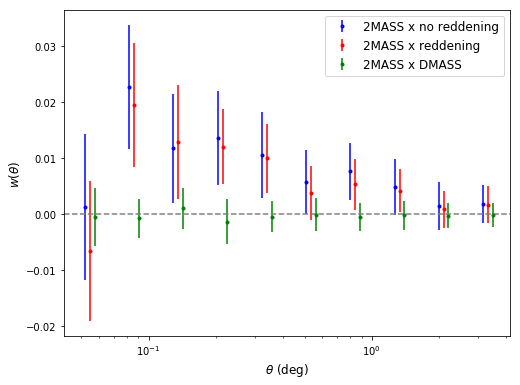

In [33]:
DAT = np.loadtxt('../data_txt//acf_cross_2mass_x_cmass_sgc_sys_cp_noz_weight_no_bweight_nbins10_jk100.txt')
meanr, xi, xi_err = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt('../data_txt//acf_cross_2mass_x_cmass_ngc_sys_cp_noz_weight_no_bweight_nbins10_jk100.txt')
meanr2, xi2, xi_err2 = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt('../data_txt//acf_cross_2mass_x_dmass_spt_nbins10_k_jk100.txt')
meanr3, xi3, xi_err3 = [DAT[:,i] for i in range(3)]

#DAT2 = np.loadtxt('../data_txt/acf_cross_2mass_x_dmass_spt_no4_k2.txt')
#meanr4, xi4, xi_err4 = [DAT2[:,i] for i in range(3)]

fig, ax = plt.subplots(figsize = (8, 6))
ax.errorbar(meanr*0.95, xi, yerr = xi_err, fmt = '.b', label='2MASS x no reddening')
ax.errorbar(meanr2, xi2, yerr = xi_err2, fmt = '.r', label='2MASS x reddening')
ax.errorbar(meanr3*1.05, xi3, yerr = xi_err3, fmt = '.g', label='2MASS x DMASS')
#ax.errorbar(meanr3 * 1.05, xi3, yerr = xi_err3, fmt = '.g', label='2MASS x CMASS (sgc)')
#ax.errorbar(meanr4*1.1, xi4, yerr = xi_err4, fmt = '.k', label='2MASS x DMASS 2')


ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(loc = 'best', fontsize = 12)
#ax.set_ylim(-0.05,0.2)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 12)
ax.set_ylabel(r'$w(\theta)$', fontsize = 12)
ax.axhline(y = 0.0, color = 'grey', linestyle = '--')
ax.set_xlim(2.5/60., 250/60.)
#ax.set_ylim(-0.05,0.1)



In [21]:

kmask = kmag20_mask(twomass_ngc)
kmask_s = kmag20_mask(twomass_sgc)
kmask_d = kmag20_mask(twomass_spt)

random_ind_n = np.random.choice( cmass_ngc_rand.size, size = cmass_ngc_rand.size/10)
#random_ind = np.random.choice( cmass_sgc_rand.size, size = cmass_sgc_rand.size/10)
for i in range(4):
    
    
    cross_angular_correlation(data = cmass_ngc, 
                              data2 = twomass_ngc[kmask[i]], 
                              rand = cmass_ngc_rand[random_ind_n], 
                              rand2= cmass_ngc_rand[random_ind_n], njack = 100, 
                              nbins=10,
                              weight = [True, True, None, None], 
                              dir = '../data_txt/', 
                              suffix = '_2mass_x_cmass_ngc_sys_cp_nz_weight_nbins10_jk100_k'+str(i+1) )
    """
    
    cross_angular_correlation(data = cmass_sgc, 
                              data2 = twomass_sgc[kmask_s[i]], 
                              rand = cmass_sgc_rand[random_ind], 
                              rand2= twomass_sgc_rand, njack = 100, 
                              nbins=10,
                              weight = [True, True, None, None], 
                              dir = '../data_txt/', 
                              suffix = '_2mass_x_cmass_sgc_sys_cp_nz_weight_nbins10_jk100_k'+str(i+1) )

    """
    
    
 
    cross_angular_correlation(data = dmass_spt, 
                              data2 = twomass_spt[kmask_d[i]], 
                              rand = dmass_rand, 
                              rand2= dmass_rand, njack = 100, 
                              nbins = 10,
                              weight = [None, None, None, None],
                              dir = '../data_txt/', 
                              suffix = '_2mass_x_dmass_spt_nbins10_jk100_k'+str(i+1) )

    
    
    


X (1573, 2)  centers (100, 2)  tol=1e-05  maxiter=200
26 iterations  cluster sizes: [ 9 29 15 14 21 11 13 10 19  9 10 22 19 22  7 13  7 17 14  7 18 19 27 10
 14 17  7 16 13 18 16  5 23 10 16 18 19  6 18 17 14 15 22 20 18 20  7 16
 29  5 20 24 23 18 20 13 29 18 14 10 18 23 12 16 13 24  7 24 17  5  5 23
 16  9 17 15 28 16 18 26 24  9 18 15 18  8 20 16 17 12 17 12 15 12 11  7
 20 10 10 20]
X (618806, 2)  centers (100, 2)  tol=1e-05  maxiter=200
110 iterations  cluster sizes: [5220 6701 6324 6239 6078 6444 5483 4686 7491 5589 5830 6381 6856 6054
 5230 6276 6345 6533 6317 5100 6697 7862 5836 6152 6022 6117 5020 5935
 6447 6351 6799 5877 7468 5180 6550 6610 6915 5872 5488 6230 6661 5584
 6582 6324 6254 6033 6154 7699 6884 5137 6885 6429 5439 5633 6663 5242
 7011 5624 5899 5510 6067 7097 5909 5743 6530 6583 5194 6995 6054 5292
 6070 6346 6130 5577 5215 7425 6898 6084 6802 6482 6313 6685 6310 5189
 7168 5276 6464 6929 7261 5175 6732 6048 6243 6411 5676 5493 5543 6709
 5211 7225]
. . . . . . . 

In [ ]:
DAT = np.loadtxt('../data_txt/acf_cross_2mass_x_cmass_ngc_no2_k2.txt')
meanr, xi, xi_err = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt('../data_txt/acf_cross_2mass_x_cmass_sgc_no2_k2.txt')
meanr2, xi2, xi_err2 = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt('../data_txt/acf_cross_2mass_x_dmass_spt_k2.txt')
meanr3, xi3, xi_err3 = [DAT[:,i] for i in range(3)]

DAT2 = np.loadtxt('../data_txt/acf_cross_2mass_x_dmass_spt_no4_k2.txt')
meanr4, xi4, xi_err4 = [DAT2[:,i] for i in range(3)]

fig, ax = plt.subplots(figsize = (8, 6))
ax.errorbar(meanr*0.95, xi, yerr = xi_err, fmt = '.b', label='2MASS x NGC')
ax.errorbar(meanr2, xi2, yerr = xi_err2, fmt = '.r', label='2MASS x SGC')
ax.errorbar(meanr3*1.05, xi3, yerr = xi_err3, fmt = '.g', label='2MASS x DMASS')
#ax.errorbar(meanr3 * 1.05, xi3, yerr = xi_err3, fmt = '.g', label='2MASS x CMASS (sgc)')
ax.errorbar(meanr4*1.1, xi4, yerr = xi_err4, fmt = '.k', label='2MASS x DMASS 2')


#ax.errorbar(meanr3*0.95, xi3, yerr = xi_err3, fmt = '.b', label='dmass spt rand')
#chisqr = np.sum( (xi-0.0)**2/xi_err**2 )*1./xi.size
#chisqr3 = np.sum( (xi3-0.0)**2/xi_err3**2 )*1./xi3.size    

ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(loc = 'best', fontsize = 12)
#ax.text(1.2, 0.03, r'DMASS $\chi^2$ = {:0.3f}'.format(chisqr), fontsize = 12)
#ax.text(1.2, 0.025, r'CMASS $\chi^2$ = {:0.3f}'.format(chisqr3), fontsize = 12)
#ax.set_ylim(-0.05,0.2)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 12)
ax.set_ylabel(r'$w(\theta)$', fontsize = 12)
ax.axhline(y = 0.0, color = 'grey', linestyle = '--')
ax.set_xlim(2.5/60., 250/60.)
ax.set_ylim(-0.05,0.1)


ax.set_title('0.43 < z < 0.55')

In [ ]:
spatialcheck([dmass_spt])

In [ ]:
DAT = np.loadtxt('data_txt/acf_cross_kk_2mass_x_dmass_hp_nside256.txt')
meanr, xi, xi_err = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt('data_txt/acf_cross_kk_2mass_x_cmass_ngc_hp_nside256.txt')
meanr2, xi2, xi_err2 = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt('data_txt/acf_cross_kk_2mass_x_cmass_sgc_hp_nside256.txt')
meanr3, xi3, xi_err3 = [DAT[:,i] for i in range(3)]
#DAT2 = np.loadtxt('data_txt/acf_cross_2mass_x_cmass.txt')
#meanr4, xi4, xi_err4 = [DAT2[:,i] for i in range(3)]

fig, ax = plt.subplots(figsize = (8, 6))
ax.errorbar(meanr*0.95, xi, yerr = xi_err, fmt = '.b', label='2MASS x DMASS')
ax.errorbar(meanr2, xi2, yerr = xi_err2, fmt = '.r', label='2MASS x CMASS (ngc)')
#ax.errorbar(meanr*1.05, xi, yerr = xi_err, fmt = '.r', label='dmass spt low')
ax.errorbar(meanr3 * 1.05, xi3, yerr = xi_err3, fmt = '.g', label='2MASS x CMASS (sgc)')
#ax.errorbar(meanr4*1.05, xi4, yerr = xi_err4, fmt = '.k', label='2MASS x cmass(sgc)')


#ax.errorbar(meanr3*0.95, xi3, yerr = xi_err3, fmt = '.b', label='dmass spt rand')
chisqr = np.sum( (xi-0.0)**2/xi_err**2 )*1./xi.size
chisqr3 = np.sum( (xi3-0.0)**2/xi_err3**2 )*1./xi3.size    

ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(loc = 'best', fontsize = 12)
#ax.text(1.2, 0.03, r'DMASS $\chi^2$ = {:0.3f}'.format(chisqr), fontsize = 12)
#ax.text(1.2, 0.025, r'CMASS $\chi^2$ = {:0.3f}'.format(chisqr3), fontsize = 12)
#ax.set_ylim(-0.05,0.2)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 12)
ax.set_ylabel(r'$w(\theta)$', fontsize = 12)
ax.axhline(y = 0.0, color = 'grey', linestyle = '--')
ax.set_xlim(10/60., 1000/60.)
ax.set_ylim(-0.02,0.02)

In [ ]:
DAT = np.loadtxt('data_txt/acf_cross_kk_2mass_x_dmass_hp_no4.txt')
meanr, xi, xi_err = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt('data_txt/acf_cross_kk_2mass_x_cmass_ngc_hp_no4.txt')
meanr2, xi2, xi_err2 = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt('data_txt/acf_cross_kk_2mass_x_cmass_sgc_hp_no4.txt')
meanr3, xi3, xi_err3 = [DAT[:,i] for i in range(3)]
#DAT2 = np.loadtxt('data_txt/acf_cross_2mass_x_cmass.txt')
#meanr4, xi4, xi_err4 = [DAT2[:,i] for i in range(3)]

fig, ax = plt.subplots(figsize = (8, 6))
ax.errorbar(meanr*0.95, xi, yerr = xi_err, fmt = '.b', label='2MASS x DMASS')
ax.errorbar(meanr2, xi2, yerr = xi_err2, fmt = '.r', label='2MASS x CMASS (ngc)')
#ax.errorbar(meanr*1.05, xi, yerr = xi_err, fmt = '.r', label='dmass spt low')
ax.errorbar(meanr3 * 1.05, xi3, yerr = xi_err3, fmt = '.g', label='2MASS x CMASS (sgc)')
#ax.errorbar(meanr4*1.05, xi4, yerr = xi_err4, fmt = '.k', label='2MASS x cmass(sgc)')


#ax.errorbar(meanr3*0.95, xi3, yerr = xi_err3, fmt = '.b', label='dmass spt rand')
chisqr = np.sum( (xi-0.0)**2/xi_err**2 )*1./xi.size
chisqr3 = np.sum( (xi3-0.0)**2/xi_err3**2 )*1./xi3.size


#jkdat = np.loadtxt('data_txt/acf_cross_2mass_x_dmass_lowz0.55_no12.jk_corr')
#for i in range(1, 10):
#    ax.plot(jkdat[:,0], jkdat[:,i])
    

#jkdat = np.loadtxt('data_txt/acf_cross_2mass_x_cmass_ngc_lowz0.4_no22.jk_corr')
#for i in range(1, 10):
#    ax.plot(jkdat[:,0], jkdat[:,i])
    

ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(loc = 'best', fontsize = 12)
#ax.text(1.2, 0.03, r'DMASS $\chi^2$ = {:0.3f}'.format(chisqr), fontsize = 12)
#ax.text(1.2, 0.025, r'CMASS $\chi^2$ = {:0.3f}'.format(chisqr3), fontsize = 12)
#ax.set_ylim(-0.05,0.2)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 12)
ax.set_ylabel(r'$w(\theta)$', fontsize = 12)
ax.axhline(y = 0.0, color = 'grey', linestyle = '--')
ax.set_xlim(10/60., 1000/60.)
ax.set_ylim(-0.02,0.02)

In [ ]:
DAT = np.loadtxt('data_txt/acf_cross_kk_2mass_x_dmass_hp_no5.txt')
meanr, xi, xi_err = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt('data_txt/acf_cross_kk_2mass_x_cmass_ngc_hp_no5.txt')
meanr2, xi2, xi_err2 = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt('data_txt/acf_cross_kk_2mass_x_cmass_sgc_hp_no5.txt')
meanr3, xi3, xi_err3 = [DAT[:,i] for i in range(3)]
#DAT2 = np.loadtxt('data_txt/acf_cross_2mass_x_cmass.txt')
#meanr4, xi4, xi_err4 = [DAT2[:,i] for i in range(3)]

fig, ax = plt.subplots(figsize = (8, 6))
ax.errorbar(meanr*0.95, xi, yerr = xi_err, fmt = '.b', label='2MASS x DMASS')
ax.errorbar(meanr2, xi2, yerr = xi_err2, fmt = '.r', label='2MASS x CMASS (ngc)')
#ax.errorbar(meanr*1.05, xi, yerr = xi_err, fmt = '.r', label='dmass spt low')
ax.errorbar(meanr3 * 1.05, xi3, yerr = xi_err3, fmt = '.g', label='2MASS x CMASS (sgc)')
#ax.errorbar(meanr4*1.05, xi4, yerr = xi_err4, fmt = '.k', label='2MASS x cmass(sgc)')


#ax.errorbar(meanr3*0.95, xi3, yerr = xi_err3, fmt = '.b', label='dmass spt rand')
chisqr = np.sum( (xi-0.0)**2/xi_err**2 )*1./xi.size
chisqr3 = np.sum( (xi3-0.0)**2/xi_err3**2 )*1./xi3.size


#jkdat = np.loadtxt('data_txt/acf_cross_2mass_x_dmass_lowz0.55_no12.jk_corr')
#for i in range(1, 10):
#    ax.plot(jkdat[:,0], jkdat[:,i])
    

#jkdat = np.loadtxt('data_txt/acf_cross_2mass_x_cmass_ngc_lowz0.4_no22.jk_corr')
#for i in range(1, 10):
#    ax.plot(jkdat[:,0], jkdat[:,i])
    

ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(loc = 'best', fontsize = 12)
#ax.text(1.2, 0.03, r'DMASS $\chi^2$ = {:0.3f}'.format(chisqr), fontsize = 12)
#ax.text(1.2, 0.025, r'CMASS $\chi^2$ = {:0.3f}'.format(chisqr3), fontsize = 12)
#ax.set_ylim(-0.05,0.2)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 12)
ax.set_ylabel(r'$w(\theta)$', fontsize = 12)
ax.axhline(y = 0.0, color = 'grey', linestyle = '--')
ax.set_xlim(10/60., 1000/60.)
ax.set_ylim(-0.02,0.02)

In [ ]:
#cmass = cmass[cmass['Z'] < 0.43]
#random = random[random['Z'] < 0.43]
#dmass_spt = dmass_spt[dmass_spt['DESDM_ZP'] < 0.43]

In [ ]:
#2MASS RANDOMS
twomass_random = uniform_random_on_sphere(twomass, size = twomass.size * 30 )
HPind_rand = hpRaDecToHEALPixel(twomass_random['RA'], twomass_random['DEC'], nside=  512, nest= False)
reliable_rand_mask = np.in1d(HPind_rand, reliable_hpind)
reliable_twomass_random =  twomass_random[reliable_rand_mask]

In [ ]:
cmass_hp512 = hpRaDecToHEALPixel(cmass['RA'], cmass['DEC'], nside=  512, nest= False)
cmass_random_hp512 = hpRaDecToHEALPixel(random['RA'], random['DEC'], nside=  512, nest= False)
dmass_hp512 = hpRaDecToHEALPixel(dmass_spt['RA'], dmass_spt['DEC'], nside=  512, nest= False)
dmass_random_hp512 = hpRaDecToHEALPixel(dmass_random['RA'], dmass_random['DEC'], nside=  512, nest= False)

#twomass_hp4096 = hpRaDecToHEALPixel(reliable_twomass['RA'], reliable_twomass['DEC'], nside=  4096, nest= False)
#twomass_random_hp4096 = hpRaDecToHEALPixel(reliable_twomass_random['RA'], reliable_twomass_random['DEC'], nside=  4096, nest= False)
twomass_hp1024 = hpRaDecToHEALPixel(reliable_twomass['RA'], reliable_twomass['DEC'], nside=  1024, nest= False)
twomass_random_hp1024 = hpRaDecToHEALPixel(reliable_twomass_random['RA'], reliable_twomass_random['DEC'], nside=  1024, nest= False) 


In [ ]:
cmass_in_twomass_mask = np.in1d( cmass_hp512, reliable_hpind )
cmass_randoms_in_twomass_mask = np.in1d( cmass_random_hp512, reliable_hpind )
dmass_in_twomass_mask = np.in1d( dmass_hp512, reliable_hpind )
dmass_radoms_in_twomass_mask = np.in1d( dmass_random_hp512, reliable_hpind )

#twomass_in_spt_mask = np.in1d( twomass_hp4096, goldmask_hpind )
#twomass_random_in_spt_mask = np.in1d( twomass_random_hp4096, goldmask_hpind )
twomass_in_cmass_mask = np.in1d( twomass_hp1024, boss_hpind )
twomass_random_in_cmass_mask = np.in1d( twomass_random_hp1024, boss_hpind )

In [ ]:
cmass_in_twomass = cmass[cmass_in_twomass_mask]
cmass_randoms_in_twomass = random[cmass_randoms_in_twomass_mask]
dmass_in_twomass = dmass_spt[dmass_in_twomass_mask]
dmass_randoms_in_twomass = dmass_random[dmass_radoms_in_twomass_mask]

twomass_in_spt = Cuts.keepGoodRegion(reliable_twomass[reliable_twomass['DEC']<-3.0])
twomass_random_in_spt = Cuts.keepGoodRegion(reliable_twomass_random[reliable_twomass_random['DEC']<-3.0])
twomass_in_cmass = reliable_twomass[twomass_in_cmass_mask]
twomass_random_in_cmass = reliable_twomass_random[twomass_random_in_cmass_mask]

In [ ]:
w_sgc = cmass_in_twomass['WEIGHT_FKP'] * cmass_in_twomass['WEIGHT_SYSTOT']*( cmass_in_twomass['WEIGHT_CP'] + cmass_in_twomass['WEIGHT_NOZ'] - 1. )
w_rand = cmass_randoms_in_twomass['WEIGHT_FKP']
cmass_in_twomass = rf.append_fields(cmass_in_twomass,'WEIGHT', w_sgc, dtypes=w_sgc.dtype)
cmass_randoms_in_twomass = rf.append_fields(cmass_randoms_in_twomass,'WEIGHT_RAND', w_rand, dtypes=w_rand.dtype)

w_twomass = np.ones(twomass_in_cmass.size)
w_twomass_rand = np.ones(twomass_random_in_cmass.size)
twomass_in_cmass = rf.append_fields(twomass_in_cmass,'WEIGHT', w_twomass)
twomass_random_in_cmass = rf.append_fields(twomass_random_in_cmass,'WEIGHT_RAND', w_twomass_rand)

w_dmass = np.ones(dmass_in_twomass.size)
w_dmass_rand = np.ones(dmass_randoms_in_twomass.size)
dmass_in_twomass = rf.append_fields(dmass_in_twomass,'WEIGHT', w_dmass)
dmass_randoms_in_twomass = rf.append_fields(dmass_randoms_in_twomass,'WEIGHT_RAND', w_dmass_rand)

w_dmass = np.ones(twomass_in_spt.size)
w_dmass_rand = np.ones(twomass_random_in_spt.size)
twomass_in_spt = rf.append_fields(twomass_in_spt,'WEIGHT', w_dmass)
twomass_random_in_spt = rf.append_fields(twomass_random_in_spt,'WEIGHT_RAND', w_dmass_rand)


In [ ]:
print 'catalog size cmass', cmass_in_twomass.size, cmass_randoms_in_twomass.size
print 'catalog size dmass', dmass_in_twomass.size, dmass_randoms_in_twomass.size
print 'catalog size 2mass', twomass_in_cmass.size, twomass_random_in_cmass.size
print 'catalog size 2mass', twomass_in_spt.size, twomass_random_in_spt.size


In [ ]:
dmass_in_twomass_galmap= making_healpix_density_map(cat = dmass_in_twomass, nside = 128, nest = False)
cmass_in_twomass_galmap= making_healpix_density_map(cat = cmass_in_twomass, nside = 128, nest = False)
hp.mollview(cmass_in_twomass_galmap['WEIGHT'] + dmass_in_twomass_galmap['WEIGHT'], nest=False, title="CMASS NGC gal density", max = 5e05)
hp.mollview(cmass_in_twomass_galmap['WEIGHT'], nest=False, title="CMASS NGC gal density", max = 5e03)


cmass_randoms_in_twomass_galmap= making_healpix_density_map(cat = cmass_randoms_in_twomass, nside = 128, nest = False)
dmass_randoms_in_twomass_galmap= making_healpix_density_map(cat = dmass_randoms_in_twomass, nside = 128, nest = False)
hp.mollview(cmass_randoms_in_twomass_galmap['WEIGHT']+dmass_randoms_in_twomass_galmap['WEIGHT'], nest=False, title="CMASS RANDOM gal density", max = 5e07)

twomass_in_cmass_galmap= making_healpix_density_map(cat = twomass_in_cmass, nside = 128, nest = False)
twomass_in_spt_galmap= making_healpix_density_map(cat = twomass_in_spt, nside = 128, nest = False)
hp.mollview(twomass_in_cmass_galmap['WEIGHT']+twomass_in_spt_galmap['WEIGHT'], nest=False, title="2MASS gal density", max = 5e05)

twomass_random_in_cmass_galmap= making_healpix_density_map(cat = twomass_random_in_cmass, nside = 128, nest = False)
twomass_random_in_spt_galmap= making_healpix_density_map(cat = twomass_random_in_spt, nside = 128, nest = False)
hp.mollview(twomass_random_in_cmass_galmap['WEIGHT']+twomass_random_in_spt_galmap['WEIGHT'], nest=False, title="2MASS gal density", max = 5e05)

#### Cross Correlation Function

In [ ]:
from systematics_module.corr import angular_correlation, cross_angular_correlation

In [ ]:
"""
angular_correlation(data = cmass_in_twomass, 
                    rand = cmass_randoms_in_twomass2, 
                    weight = True, suffix = '_cmass_in_twomass', njack=10)

angular_correlation(data = twomass_in_cmass, 
                    rand = twomass_random_in_cmass, 
                    weight = True, suffix = '_twomass_in_cmass', njack=10)

angular_correlation(data = dmass_in_twomass, 
                    rand = dmass_random_in_twomass, 
                    weight = True, suffix = '_dmass_in_twomass', njack=10)
"""

In [ ]:

random_ind = np.random.choice(np.arange(cmass_randoms_in_twomass.size), size = cmass_randoms_in_twomass.size/10)

cross_angular_correlation(data = cmass_in_twomass, 
                          data2 = twomass_in_cmass, 
                          rand = cmass_randoms_in_twomass[random_ind], 
                          rand2= twomass_random_in_cmass, njack = 30,  
                          weight = [None, None, None, None], suffix = '_2mass_x_cmass_ngc_zfull_no26' )

cross_angular_correlation(data = dmass_in_twomass, 
                          data2 = twomass_in_spt, 
                          rand = dmass_randoms_in_twomass, 
                          rand2= twomass_random_in_spt, njack = 30,  
                          weight = [None, None, None, None], suffix = '_2mass_x_dmass_zfull_no16')

In [ ]:
DAT = np.loadtxt('data_txt/acf_cross_2mass_x_dmass_zfull_no16.txt')
meanr, xi, xi_err = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt('data_txt/acf_cross_2mass_x_cmass_ngc_zfull_no26.txt')
meanr3, xi3, xi_err3 = [DAT[:,i] for i in range(3)]
#DAT2 = np.loadtxt('data_txt/acf_cross_2mass_x_cmass.txt')
#meanr4, xi4, xi_err4 = [DAT2[:,i] for i in range(3)]

fig, ax = plt.subplots(figsize = (8, 6))
ax.errorbar(meanr*0.95, xi, yerr = xi_err, fmt = '.b', label='2MASS x dmass')
#ax.errorbar(meanr2, xi2, yerr = xi_err2, fmt = '.r', label='cmass auto')
#ax.errorbar(meanr*1.05, xi, yerr = xi_err, fmt = '.r', label='dmass spt low')
ax.errorbar(meanr3, xi3, yerr = xi_err3, fmt = '.r', label='2MASS x cmass')
#ax.errorbar(meanr4*1.05, xi4, yerr = xi_err4, fmt = '.k', label='2MASS x cmass(sgc)')


#ax.errorbar(meanr3*0.95, xi3, yerr = xi_err3, fmt = '.b', label='dmass spt rand')
chisqr = np.sum( (xi-0.0)**2/xi_err**2 )*1./xi.size
chisqr3 = np.sum( (xi3-0.0)**2/xi_err3**2 )*1./xi3.size


#jkdat = np.loadtxt('data_txt/acf_cross_2mass_x_dmass_lowz0.55_no12.jk_corr')
#for i in range(1, 10):
#    ax.plot(jkdat[:,0], jkdat[:,i])
    

#jkdat = np.loadtxt('data_txt/acf_cross_2mass_x_cmass_ngc_lowz0.4_no22.jk_corr')
#for i in range(1, 10):
#    ax.plot(jkdat[:,0], jkdat[:,i])
    

ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(loc = 'best', fontsize = 12)
ax.text(1.2, 0.03, r'DMASS $\chi^2$ = {:0.3f}'.format(chisqr), fontsize = 12)
ax.text(1.2, 0.025, r'CMASS $\chi^2$ = {:0.3f}'.format(chisqr3), fontsize = 12)
ax.set_ylim(-0.05,0.05)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 12)
ax.set_ylabel(r'$w(\theta)$', fontsize = 12)
ax.axhline(y = 0.0, color = 'grey', linestyle = '--')

In [ ]:
DAT = np.loadtxt('data_txt/acf_cross_2mass_x_dmass_lowz0.4_no15.txt')
meanr, xi, xi_err = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt('data_txt/acf_cross_2mass_x_cmass_ngc_lowz0.4_no25.txt')
meanr3, xi3, xi_err3 = [DAT[:,i] for i in range(3)]
#DAT2 = np.loadtxt('data_txt/acf_cross_2mass_x_cmass.txt')
#meanr4, xi4, xi_err4 = [DAT2[:,i] for i in range(3)]

fig, ax = plt.subplots(figsize = (8, 6))
ax.errorbar(meanr*0.95, xi, yerr = xi_err, fmt = '.b', label='2MASS x dmass (z<0.43)')
#ax.errorbar(meanr2, xi2, yerr = xi_err2, fmt = '.r', label='cmass auto')
#ax.errorbar(meanr*1.05, xi, yerr = xi_err, fmt = '.r', label='dmass spt low')
ax.errorbar(meanr3, xi3, yerr = xi_err3, fmt = '.r', label='2MASS x cmass (z<0.43)')
#ax.errorbar(meanr4*1.05, xi4, yerr = xi_err4, fmt = '.k', label='2MASS x cmass(sgc)')


#ax.errorbar(meanr3*0.95, xi3, yerr = xi_err3, fmt = '.b', label='dmass spt rand')
chisqr = np.sum( (xi-0.0)**2/xi_err**2 )*1./xi.size
chisqr3 = np.sum( (xi3-0.0)**2/xi_err3**2 )*1./xi3.size


#jkdat = np.loadtxt('data_txt/acf_cross_2mass_x_dmass_lowz0.55_no12.jk_corr')
#for i in range(1, 10):
#    ax.plot(jkdat[:,0], jkdat[:,i])
    

#jkdat = np.loadtxt('data_txt/acf_cross_2mass_x_cmass_ngc_lowz0.4_no22.jk_corr')
#for i in range(1, 10):
#    ax.plot(jkdat[:,0], jkdat[:,i])
    

ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(loc = 'best', fontsize = 12)
ax.text(1.2, 0.03, r'DMASS $\chi^2$ = {:0.3f}'.format(chisqr), fontsize = 12)
ax.text(1.2, 0.025, r'CMASS $\chi^2$ = {:0.3f}'.format(chisqr3), fontsize = 12)
ax.set_ylim(-0.05,0.05)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 12)
ax.set_ylabel(r'$w(\theta)$', fontsize = 12)
ax.axhline(y = 0.0, color = 'grey', linestyle = '--')

In [ ]:
DAT = np.loadtxt('data_txt/acf_cross_2mass_x_cmass_sgc_lowz0.4_no17.txt')
meanr, xi, xi_err = [DAT[:,i] for i in range(3)]

#DAT = np.loadtxt('data_txt/acf_cross_2mass_x_cmass_full_lowz0.4_no12.txt')
DAT = np.loadtxt('data_txt/acf_cross_2mass_x_dmass_lowz0.55_no9.txt')
meanr2, xi2, xi_err2 = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt('data_txt/acf_cross_2mass_x_cmass_ngc_lowz0.4_no18.txt')
meanr3, xi3, xi_err3 = [DAT[:,i] for i in range(3)]
#DAT2 = np.loadtxt('data_txt/acf_cross_2mass_x_cmass.txt')
#meanr4, xi4, xi_err4 = [DAT2[:,i] for i in range(3)]

fig, ax = plt.subplots(figsize = (8, 6))
#ax.errorbar(meanr2*0.95, xi2, yerr = xi_err2, fmt = '.r', label='z_photo < 0.55, DMASS')
ax.errorbar(meanr, xi, yerr = xi_err, fmt = '.b', label='z < 0.43, SGC')
#ax.errorbar(meanr*1.05, xi, yerr = xi_err, fmt = '.r', label='dmass spt low')
ax.errorbar(meanr3*1.05, xi3, yerr = xi_err3, fmt = '.g', label='z < 0.43, NGC')
#ax.errorbar(meanr4*1.05, xi4, yerr = xi_err4, fmt = '.k', label='2MASS x cmass(sgc)')


#ax.errorbar(meanr3*0.95, xi3, yerr = xi_err3, fmt = '.b', label='dmass spt rand')
chisqr = np.sum( (xi-0.0)**2/xi_err**2 )*1./xi.size
chisqr3 = np.sum( (xi3-0.0)**2/xi_err3**2 )*1./xi3.size



ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(loc = 'best', fontsize = 12)
ax.text(1.2, 0.028, r'SGC $\chi^2$ = {:0.3f}'.format(chisqr), fontsize = 12)
ax.text(1.2, 0.022, r'NGC $\chi^2$ = {:0.3f}'.format(chisqr3), fontsize = 12)
ax.set_ylim(-0.05,0.05)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 12)
ax.set_ylabel(r'$w(\theta)$', fontsize = 12)
ax.axhline(y = 0.0, color = 'grey', linestyle = '--')
ax.set_title('2MASS x CMASS')

In [ ]:

dmass_in_twomass_galmap= making_healpix_density_map(cat = dmass_in_twomass, nside = 128, nest = False)
hp.mollview(dmass_in_twomass_galmap['WEIGHT'], nest=False, title="DMASS gal density", max = 5e05)

dmass_random_in_twomass_galmap= making_healpix_density_map(cat = dmass_random_in_twomass, nside = 128, nest = False)
hp.mollview(dmass_random_in_twomass['WEIGHT'], nest=False, title="DMASS gal density", max = 5e05)

twomass_in_spt_galmap= making_healpix_density_map(cat = twomass_in_spt, nside = 128, nest = False)
hp.mollview(twomass_in_spt['WEIGHT'], nest=False, title="2MASS spt gal density", max = 5e05)

twomass_random_in_spt_galmap= making_healpix_density_map(cat = twomass_random_in_spt, nside = 128, nest = False)
hp.mollview(twomass_random_in_spt_galmap['WEIGHT'], nest=False, title="2MASS spt gal density", max = 5e05)


cross_angular_correlation(data = dmass_in_twomass_galmap, 
                          data2 = twomass_in_spt_galmap, 
                          rand = dmass_randoms_in_twomass_galmap, 
                          rand2= twomass_random_in_spt_galmap, njack = 20,  
                          weight = [True, True, True, True], suffix = '_2mass_x_dmass_hp')

In [ ]:
cov_cmass = np.genfromtxt('data_txt/acf_cross_2mass_x_cmass_ngc_zfull_no26.cov')
cov_dmass = np.loadtxt('data_txt/acf_cross_2mass_x_dmass_zfull_no16.cov')
inv_cmass = np.linalg.inv(cov_cmass)
inv_dmass = np.linalg.inv(cov_dmass)
print np.dot(np.dot(xi3, inv_cmass), xi3)*1./xi3.size
print np.dot(np.dot(xi, inv_dmass), xi)*1./xi.size

fig, ax = plt.subplots()
im = ax.imshow(cov_cmass)
fig.colorbar(im, ax=ax)